In [1]:
import cv2 as cv
import sys
import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms
import random

data = []
trans = transforms.Compose([transforms.ToTensor()])
def split_mask(mask, num_classes):
    # Список для хранения отдельных масок классов
    split_masks = []
    for class_id in range(num_classes):
        # Создаем маску для данного класса
        class_mask = (mask == class_id).astype(np.uint8)  # 1 для пикселей этого класса, 0 для остальных
        split_masks.append(class_mask)
    return split_masks

for _ in range(0, 338):
    mask = (np.load(f'C:/Users/work/labled_data/{_}.npy'))
    assert mask is not None, "file could not be read, check with os.path.exists()"
    mask = cv.resize(mask, (512, 512))
    
    img = cv.imread(f"C:/Users/work/source_data/{_}.jpg", cv.IMREAD_GRAYSCALE)
    #ret,X = cv.threshold(img,100,255,cv.THRESH_TOZERO)
    X = cv.resize(img, (512, 512))
    #b, g, r = cv.split(cv.resize(img, (256, 256)))
    #
    #X =  np.asarray([b, g, r])
    #
    #X = X.transpose(1, 2, 0)
    X = trans(X)
    data.append([X, mask])

#random.shuffle(data)   

In [2]:
from torch.utils.data import Dataset, DataLoader
dataloaders = {
    'train': DataLoader(data[0:280], batch_size=10, shuffle=True, num_workers=2),
    'val': DataLoader(data[280:338], batch_size=10, shuffle=True, num_workers=2)
}
inputs, masks = next(iter(dataloaders['train']))
print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())
    

torch.Size([10, 1, 512, 512]) torch.Size([10, 512, 512])
0.05490196 0.99607843 0.2864843 0.1646438
0 2 0.07879600524902344 0.3666328173859174


In [5]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        
        self.dconv_down5 = double_conv(512, 1024) 

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up4 = double_conv(512 + 1024, 512)
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        #print(f'conv1 size: {conv1.size()}')
    
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        #print(f'conv2 size: {conv2.size()}')
    
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        #print(f'conv3 size: {conv3.size()}')
    
        x = self.maxpool(conv3)   
        conv4 = self.dconv_down4(x)
        #print(f'conv4 size: {conv4.size()}')

        x = self.maxpool(conv4)  
        #print(f'conv4 size(after maxpool): {x.size()}')
        x = self.dconv_down5(x)
        #print(f'dconv_down5 size: {x.size()}')
    
        x = self.upsample(x)        
        #print(f'after upsample size: {x.size()}')
        x = torch.cat([x, conv4], dim=1)
        #print(f'after concat with conv4 size: {x.size()}')
    
        x = self.dconv_up4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)   
        #print(f'after upsample size: {x.size()}')
        x = torch.cat([x, conv2], dim=1)
        #print(f'after concat with conv2 size: {x.size()}')
        
        x = self.dconv_up2(x)
        x = self.upsample(x)
        #print(f'after upsample size: {x.size()}')
        x = torch.cat([x, conv1], dim=1)
        #print(f'after concat with conv1 size: {x.size()}')
        
        x = self.dconv_up1(x)
        out = self.conv_last(x)

        return out

In [11]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(3).to(device)
class_weights = torch.tensor([10.0, 70.0, 20.0])  # вес для каждого класса

# Создаем функцию потерь с весами
criterion = nn.CrossEntropyLoss(weight=class_weights) # Для регрессии используется среднеквадратичная ошибка
 

optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Цикл обучения
num_epochs = 15

for epoch in range(num_epochs):
    model.train()  # Установка модели в режим обучения
    total_loss = 0

    for inputs, targets in dataloaders['train']:
        start_time = time.time()  # Запоминаем текущее вре
        optimizer.zero_grad()  # Обнуление градиентов
        outputs = model(inputs)  # Прямой проход
        loss = criterion(outputs, targets.type(torch.LongTensor))  # Вычисление потерь
        loss.backward()  # Обратный проход
        optimizer.step()  # Шаг оптимизации
        total_loss += loss.item()
        print(loss.item())
        end_time = time.time()  # Запоминаем время после выполнения функции
        execution_time = end_time - start_time  # Вычисляем время выполнения
        print(f"Время выполнения: {execution_time:.6f} секунд")
        

    avg_train_loss = total_loss / len(dataloaders['train'])
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}')

    model.eval()  # Установка модели в режим валидации
    total_val_loss = 0

    with torch.no_grad():  # Отключаем градиенты
        for inputs, targets in dataloaders['val']:
            outputs = model(inputs)
            
            loss = criterion(outputs, targets.type(torch.LongTensor))
            
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(dataloaders['val'])
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}')
    
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
        }, 'C:/Users/work/FILTERS/Models/model_weave_1024.pth')
print("Обучение завершено!")

1.0406533479690552
Время выполнения: 162.540019 секунд
1.036827564239502
Время выполнения: 164.792809 секунд
1.033007264137268
Время выполнения: 160.565670 секунд
1.0301213264465332
Время выполнения: 172.834307 секунд
1.027563452720642
Время выполнения: 164.213518 секунд
1.0215089321136475
Время выполнения: 171.901963 секунд
1.0189257860183716
Время выполнения: 163.288198 секунд
1.0122389793395996
Время выполнения: 175.000656 секунд
1.0009171962738037
Время выполнения: 171.599594 секунд
0.969282329082489
Время выполнения: 186.125759 секунд
Epoch 1/15, Training Loss: 1.0191
Epoch 1/15, Validation Loss: 0.8950
0.9191165566444397
Время выполнения: 129.688498 секунд
0.7903313636779785
Время выполнения: 153.196315 секунд
0.7944645285606384
Время выполнения: 127.076036 секунд
0.7758653163909912
Время выполнения: 125.552339 секунд
0.7161346077919006
Время выполнения: 128.976690 секунд
0.7252761721611023
Время выполнения: 130.066702 секунд
0.7193255424499512
Время выполнения: 126.964814 секунд

In [112]:
import math

model.eval()   
test_loader = DataLoader(data[150:198], batch_size=2, shuffle=False, num_workers=0)

# Get the first batch
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)


# Predict
#pred = model(inputs)

In [113]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(3)
state_dict = torch.load('C:/Users/work/FILTERS/Models/model_weave_1024_x_circ_512_ep14_14.pth')['model_state_dict']
model.load_state_dict(state_dict, strict=True)
model.eval()
with torch.no_grad():  # Отключаем градиенты
    output = model(inputs)

C:\Users\work\AppData\Local\Temp\ipykernel_9164\763369188.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('C:/Users/work/FILTERS/Models/model_wea

In [114]:
import torch.nn.functional as F

# Для получения вероятностей

probabilities = F.softmax(output, dim=1)  # Применяем софтмакс по каналам
probabilities[0][1].max()
# Предсказанные классы
#predicted_classes = nn.Softmax(dim=1)(pred)

tensor(0.9994)

In [115]:
probabilities[0][1].min()


probabilities[0][1][probabilities[0][1]<0.76] = 0

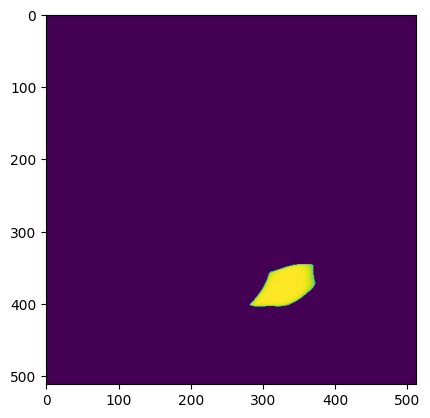

In [116]:
plt.imshow((probabilities[0][1]).detach())


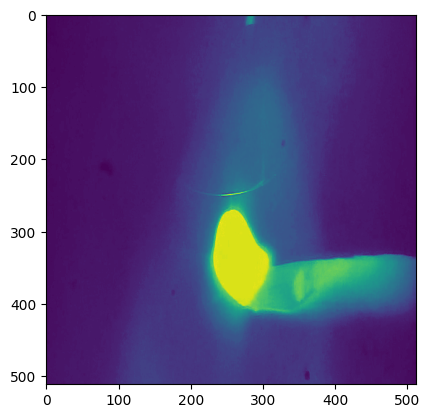

In [117]:
plt.imshow((data[150][0][0]))

In [74]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(3).to(device)
checkpoint = torch.load('C:/Users/work/FILTERS/Models/model_weave_1024_x_circ_512_ep14.pth')
model.load_state_dict(checkpoint['model_state_dict'])


# Создаем функцию потерь с весами
criterion = nn.CrossEntropyLoss() # Для регрессии используется среднеквадратичная ошибка
 

optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# Цикл обучения
num_epochs = 15

for epoch in range(num_epochs):
    model.train()  # Установка модели в режим обучения
    total_loss = 0

    for inputs, targets in dataloaders['train']:
        start_time = time.time()  # Запоминаем текущее вре
        optimizer.zero_grad()  # Обнуление градиентов
        outputs = model(inputs)  # Прямой проход
        loss = criterion(outputs, targets.type(torch.LongTensor))  # Вычисление потерь
        loss.backward()  # Обратный проход
        optimizer.step()  # Шаг оптимизации
        total_loss += loss.item()
        print(loss.item())
        end_time = time.time()  # Запоминаем время после выполнения функции
        execution_time = end_time - start_time  # Вычисляем время выполнения
        print(f"Время выполнения: {execution_time:.6f} секунд")
        

    avg_train_loss = total_loss / len(dataloaders['train'])
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}')

    model.eval()  # Установка модели в режим валидации
    total_val_loss = 0

    with torch.no_grad():  # Отключаем градиенты
        for inputs, targets in dataloaders['val']:
            outputs = model(inputs)
            
            loss = criterion(outputs, targets.type(torch.LongTensor))
            
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(dataloaders['val'])
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}')
    
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
        }, f'C:/Users/work/FILTERS/Models/model_weave_1024_x_circ_512_ep14_{epoch}.pth')
print("Обучение завершено!")

C:\Users\work\AppData\Local\Temp\ipykernel_19012\4113502971.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('C:/Users/work/FILTERS/Models/model_w

0.015748735517263412
Время выполнения: 59.388527 секунд
0.020655978471040726
Время выполнения: 70.023199 секунд
0.015754368156194687
Время выполнения: 60.111977 секунд
0.031983837485313416
Время выполнения: 58.462757 секунд
0.01589459553360939
Время выполнения: 58.485991 секунд
0.015339501202106476
Время выполнения: 57.952081 секунд
0.01779591478407383
Время выполнения: 58.355107 секунд
0.016591230407357216
Время выполнения: 56.805730 секунд
0.02326979860663414
Время выполнения: 57.810711 секунд
0.017135456204414368
Время выполнения: 58.312866 секунд
0.018879707902669907
Время выполнения: 57.741619 секунд
0.014108754694461823
Время выполнения: 62.472488 секунд
0.019150298088788986
Время выполнения: 62.939000 секунд
0.014327940531075
Время выполнения: 56.862967 секунд
0.034208815544843674
Время выполнения: 65.752316 секунд
0.02240033820271492
Время выполнения: 62.707021 секунд
0.017005594447255135
Время выполнения: 62.526784 секунд
0.015089467167854309
Время выполнения: 60.881784 секунд